In [ ]:
# pip install -q opencv-python
# !pip install --upgrade pyreadline
# !pip install torchsummary 
# !pip install --upgrade fastai

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import argparse

In [ ]:
import generate_opencv_gt_images

In [ ]:
from fastai.vision.all import *

In [ ]:
from torch.utils.tensorboard import SummaryWriter
torch.cuda.memory_allocated(0) / 1024.0 / 1024.

0.0

In [ ]:
generate_data = True
args = argparse.Namespace()
args.output_dir = "test1_train"
args.debug = False
args.num_drawings = 5000
args.num_images_per_drawing = 1
if generate_data:
    generate_opencv_gt_images.run(args)

In run, args is  Namespace(debug=False, num_drawings=5000, num_images_per_drawing=1, output_dir='test1_train')
Generating 0 / 5000
Generating 1 / 5000
Generating 2 / 5000
Generating 3 / 5000
Generating 4 / 5000
Generating 5 / 5000
Generating 6 / 5000
Generating 7 / 5000
Generating 8 / 5000
Generating 9 / 5000
Generating 10 / 5000
Generating 11 / 5000
Generating 12 / 5000
Generating 13 / 5000
Generating 14 / 5000
Generating 15 / 5000
Generating 16 / 5000
Generating 17 / 5000
Generating 18 / 5000
Generating 19 / 5000
Generating 20 / 5000
Generating 21 / 5000
Generating 22 / 5000
Generating 23 / 5000
Generating 24 / 5000
Generating 25 / 5000
Generating 26 / 5000
Generating 27 / 5000
Generating 28 / 5000
Generating 29 / 5000
Generating 30 / 5000
Generating 31 / 5000
Generating 32 / 5000
Generating 33 / 5000
Generating 34 / 5000
Generating 35 / 5000
Generating 36 / 5000
Generating 37 / 5000
Generating 38 / 5000
Generating 39 / 5000
Generating 40 / 5000
Generating 41 / 5000
Generating 42 / 5

In [ ]:
input_path = Path(args.output_dir)
input_path.ls()

(#20000) [Path('test1_train/img-00059-000.rendered.png'),Path('test1_train/img-02677-000.json'),Path('test1_train/img-04755-000.rendered.png'),Path('test1_train/img-04764-000.labels.png'),Path('test1_train/img-01601-000.aliased.png'),Path('test1_train/img-04501-000.json'),Path('test1_train/img-02952-000.aliased.png'),Path('test1_train/img-04334-000.json'),Path('test1_train/img-02590-000.json'),Path('test1_train/img-03019-000.json')...]

In [ ]:
def get_dl_image_files(path):
    return [path / f.stem for f in path.glob("img-?????-???.json")]

def get_dl_target_image(fprefix: Path):
    return fprefix.with_suffix(".aliased.png")

def get_dl_source_image(fprefix: Path):
    return fprefix.with_suffix(".rendered.png")

In [ ]:
# input_prefixes = get_dl_image_files(input_path)
# images = [f.with_suffix(".rendered.png") for f in input_prefixes]
# pil_images = [PILImage.create(f) for f in images]
# show_images(pil_images)

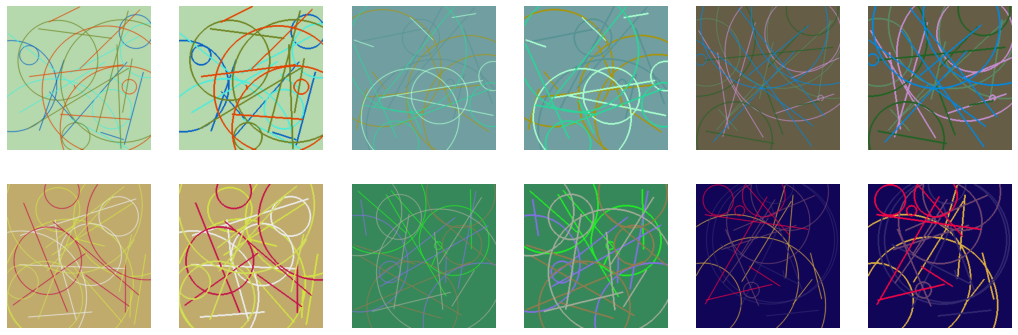

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                           get_items = get_dl_image_files,
                           get_y     = get_dl_target_image,
                           get_x     = get_dl_source_image,                   
                           splitter  = RandomSplitter())
dls = dblock.dataloaders(input_path, bs=6)
dsets = dblock.datasets(input_path)
dls.show_batch()

In [ ]:
mean, std = model_meta.get(models.resnet18)['stats']
mean = torch.tensor(mean).cuda()
std = torch.tensor(std).cuda()
# print (mean, std)
# dls.c = 3 # number of outputs
# dblock.summary(input_path)
def metric_l1_raw_image(x,y):
    #print (x.shape)
    #print (y.shape)
    # * std + mean
    diff = (x-y).abs()
    # print (diff)
    # print (255.0*diff)
    for c in range(0,3):
        diff[:,c,:,:] *= std[c] # FIXME there must be a way to avoid the loop
    #print (255.0*diff)
    return 255.0 * diff.mean()

In [ ]:
learn = unet_learner(dls, arch=models.resnet18, loss_func=nn.MSELoss(), n_out=3, metrics=AvgMetric(metric_l1_raw_image))

In [ ]:
#dblock.summary(input_path)

In [ ]:
# learn.load("model1.ai")

In [ ]:
# writer = SummaryWriter()
# writer.add_graph(learn.model.cpu(), first(dls.valid)[0].cpu())

In [ ]:
# learn.lr_find()

In [ ]:
print ('Occupied mem: ', torch.cuda.memory_allocated(0) / 1024.0 / 1024.)

Occupied mem:  0.001953125


In [ ]:
learn.lr = 2e-3
learn.fine_tune(40)

epoch,train_loss,valid_loss,metric_l1_raw_image,time
0,0.093059,0.007245,3.341642,03:43


epoch,train_loss,valid_loss,metric_l1_raw_image,time
0,0.051833,0.003372,1.733991,03:50
1,0.043486,0.002933,1.634725,03:50
2,0.037529,0.002625,1.591421,03:50
3,0.032886,0.002225,1.431803,03:52
4,0.028352,0.002077,1.477372,03:52
5,0.025240,0.001853,1.239112,03:52
6,0.024199,0.001784,1.344914,03:52
7,0.022509,0.002708,2.065991,03:52
8,0.020034,0.001489,1.132476,03:52
9,0.019041,0.001511,1.159964,03:52


In [ ]:
b = dls.valid.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

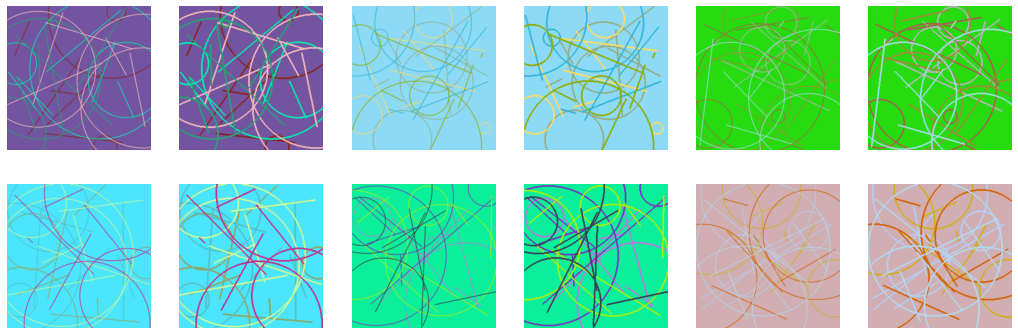

In [ ]:
dls.show_batch()

In [ ]:
learn.save("model2.ai")

Path('models/model2.ai.pth')

TensorImage([157, 120, 154])

TensorImage([0.5866, 0.0666, 0.8914])

TensorImage([0.5866, 0.0666, 0.8914])

TensorImage([149.5842,  16.9721, 227.3189])

TensorImage([138,  33, 229])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 1 is out of bounds for dimension 1 with size 1

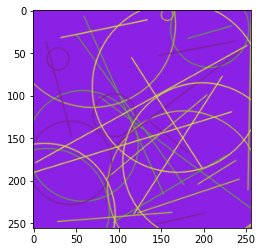

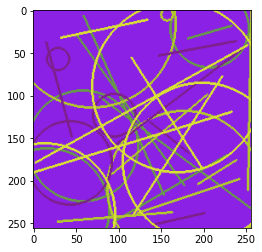

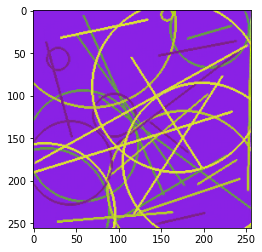

In [ ]:
# FIXME: why the valid metric does not match the typical values we find here of ~2

input = dls.decode_batch(dls.one_batch())[0]
test_img = input[0]
gt_img = input[1]

predicted_img = learn.predict(test_img)

display(predicted_img[0][:,0,0])
display(predicted_img[1][:,0,0])
display(predicted_img[2][:,0,0])
display(predicted_img[2][:,0,0]*255.0)
display(gt_img[:,0,0])

# FIXME: can't figure out the decoding actually applied to predicted_img. It seems off.
# predicted_img[2] is fine once normalized, predicted_ing[0] is supposed to be the
# perfect one but it's not.

# preds = learn.get_preds(dls.valid, with_input=True, with_decoded=True)
plt.imshow(test_img.permute(1, 2, 0))
plt.figure()
plt.imshow(gt_img.permute(1, 2, 0))
plt.figure()
plt.imshow(predicted_img[2].permute(1, 2, 0))
(gt_img - predicted_img[2]*255.0).abs().mean()
metric_l1_raw_image((gt_img / 255.0).unsqueeze(1).cuda(), predicted_img[2].unsqueeze(1).cuda())

In [ ]:
dls.decode((np.ones((1,3,256,256)), np.ones((1,3,256,256))))unsqueeze

(TensorImage([[[[182, 182, 182,  ..., 182, 182, 182],
           [182, 182, 182,  ..., 182, 182, 182],
           [182, 182, 182,  ..., 182, 182, 182],
           ...,
           [182, 182, 182,  ..., 182, 182, 182],
           [182, 182, 182,  ..., 182, 182, 182],
           [182, 182, 182,  ..., 182, 182, 182]],
 
          [[173, 173, 173,  ..., 173, 173, 173],
           [173, 173, 173,  ..., 173, 173, 173],
           [173, 173, 173,  ..., 173, 173, 173],
           ...,
           [173, 173, 173,  ..., 173, 173, 173],
           [173, 173, 173,  ..., 173, 173, 173],
           [173, 173, 173,  ..., 173, 173, 173]],
 
          [[160, 160, 160,  ..., 160, 160, 160],
           [160, 160, 160,  ..., 160, 160, 160],
           [160, 160, 160,  ..., 160, 160, 160],
           ...,
           [160, 160, 160,  ..., 160, 160, 160],
           [160, 160, 160,  ..., 160, 160, 160],
           [160, 160, 160,  ..., 160, 160, 160]]]]),
 TensorImage([[[[182, 182, 182,  ..., 182, 182, 182],
 

In [ ]:
fname = Path("./downloaded.jpg")
if fname.exists(): os.remove(fname)
# url = "https://www.r-graph-gallery.com/img/graph/lineplot-spaghetti1.png"
url = "http://www.telesens.co/wp-content/uploads/2018/03/img_5aa5827c1d42c.png"
download_url(url, fname)
assert fname.exists()

In [ ]:
Path().resolve().parent.parent.ls()

(#11) [Path('/home/jovyan/Perso/DaltonLensDrive'),Path('/home/jovyan/Perso/Plots'),Path('/home/jovyan/Perso/gpu-jupyter'),Path('/home/jovyan/Perso/start_jupyter.sh~'),Path('/home/jovyan/Perso/fastbook'),Path('/home/jovyan/Perso/.python-version'),Path('/home/jovyan/Perso/DaltonLensPrivate'),Path('/home/jovyan/Perso/course-v3'),Path('/home/jovyan/Perso/start_jupyter.sh'),Path('/home/jovyan/Perso/.ipynb_checkpoints')...]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


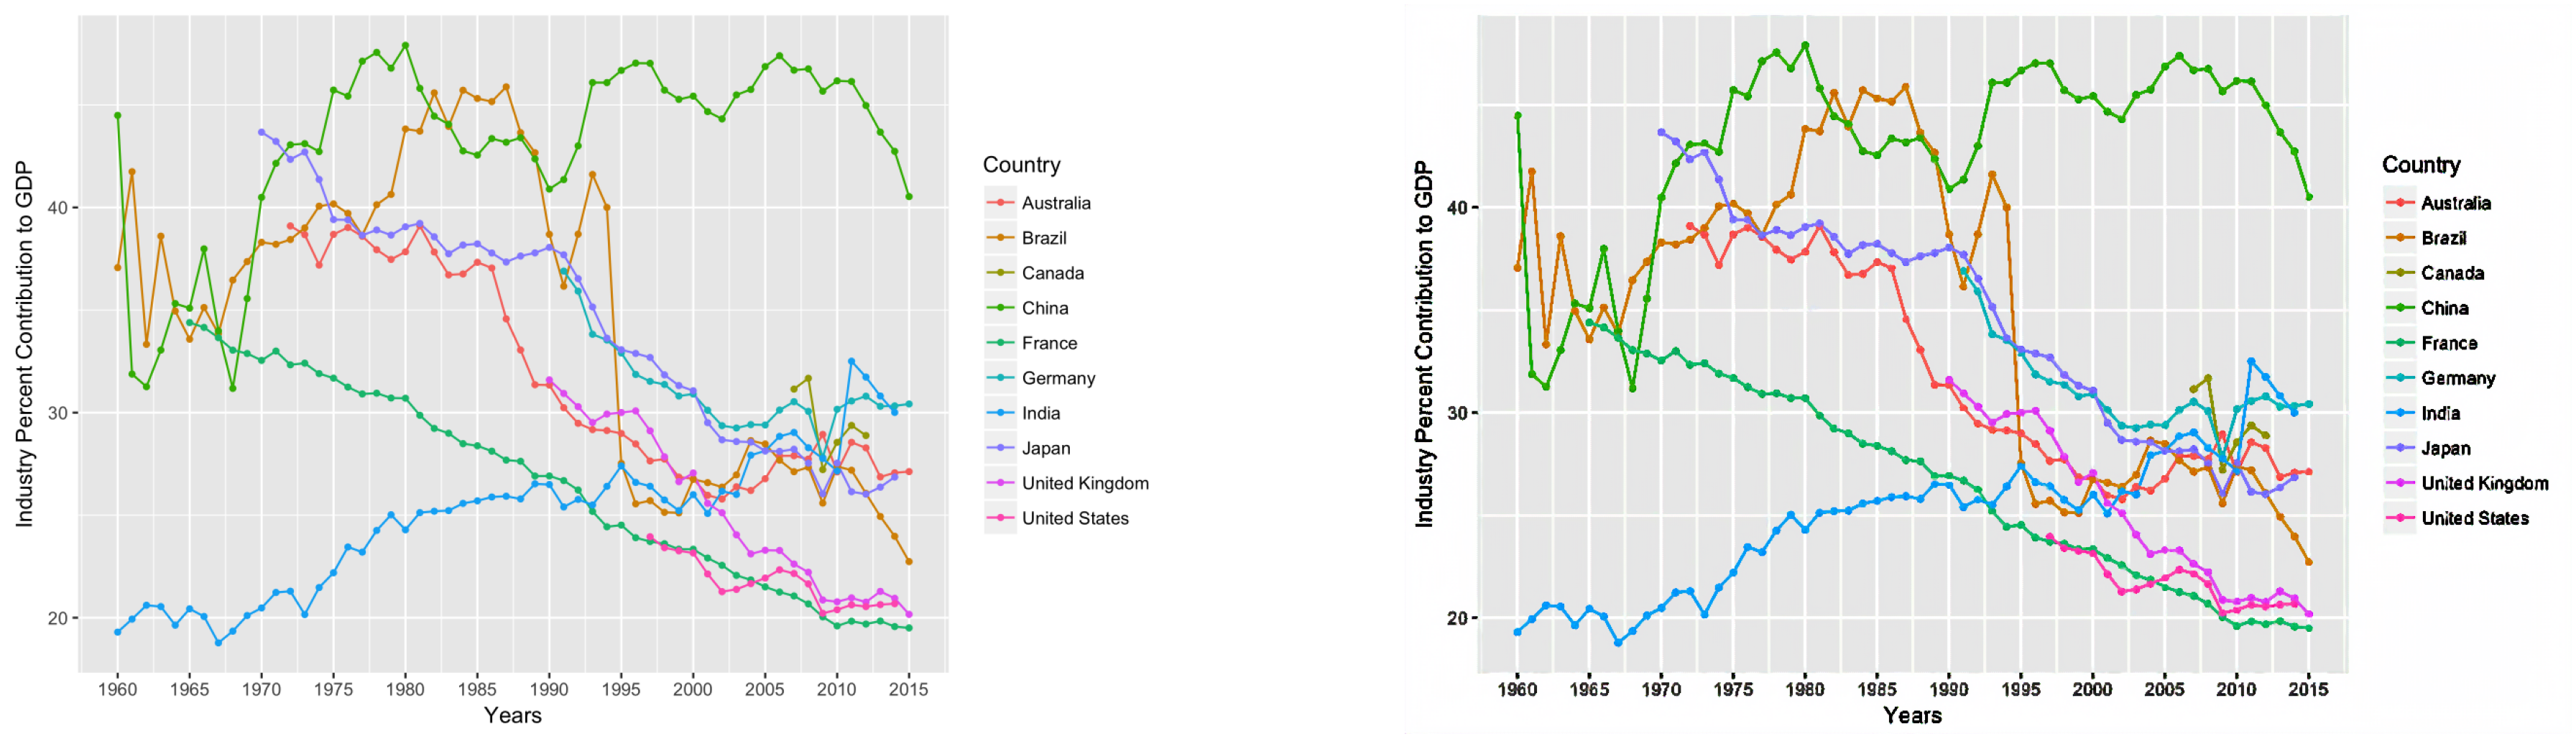

In [ ]:
fname = Path().resolve().parent.parent / 'Plots' / 'Industry_GDP.png'
input = PILImage.create(fname)
show_images([input, learn.predict(input)[2]], figsize=(64,64))

In [ ]:
class HistogramPerLabel:
    def __init__(self, im, labels):
        self.histogram = {}
        hsv_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        for l in labels:
            self.histogram[l] = compute_histogram_for_label(l, hsv_im, labels)
            
    def compute_histogram_for_label(l, hsv_im, labels):
        numpy.histogram()

In [ ]:
histogram[label][hsv] -> count

16777216

In [ ]:
def metric_segmentation_accuracy_from_color_thresholding(rgb_im, labels):
    